In [1]:
%matplotlib notebook

In [227]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'SPECIAL_TEAMS_RESULT': 'specialTeamsResult',
    'PLAY_RESULT': 'playResult', # Net difference in field position
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'RETURNER_ID': 'returnerId',
    'PRIMARY_RETURNER_ID': 'primaryReturnerId',
    'PLAYER_TEAM_ID': 'playerTeamId',
    'X': 'x',
    'Y': 'y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'DISPLAY_NAME': 'displayName',
    'KICK_RETURN_YARDAGE': 'kickReturnYardage',
    'DISTANCE_FROM_SIDELINE': 'distanceFromSideline',
    'SORT_POSITION': 'sortPosition',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'BALL_SNAP': 'ball_snap',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
    'PUNT_LAND': 'punt_land',
    'FAIR_CATCH': 'fair_catch',
    'PUNT_MUFFED': 'punt_muffed',
})

SPECIAL_TEAMS_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
    'RETURN': 'Return',
    'TOUCHBACK': 'Touchback',
    'FAIR_CATCH': 'Fair Catch',
    'MUFFED': 'Muffed',
    'OUT_OF_BOUNDS': 'Out of Bounds',
})

TEAM = SimpleNamespace(**{
    'HOME': 'home',
    'AWAY': 'away',
    'FOOTBALL': 'football',
})

In [3]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [4]:
game_plays_df = game_plays_df.dropna(subset=[COLUMN.RETURNER_ID])

def getPrimaryReturnerId(value):
    returners = str(value).split(';')
    return int(returners[0])

game_plays_df[COLUMN.PRIMARY_RETURNER_ID] = game_plays_df[COLUMN.RETURNER_ID] \
    .apply(getPrimaryReturnerId) \
    .astype('Int64')

tracking_2018_df[COLUMN.TIME] = pd.to_datetime(tracking_2018_df[COLUMN.TIME])
tracking_2018_df[COLUMN.JERSEY_NUMBER] = tracking_2018_df[COLUMN.JERSEY_NUMBER].astype('Int64')
tracking_2018_df[COLUMN.NFL_ID] = tracking_2018_df[COLUMN.NFL_ID].astype('Int64')

In [5]:
punt_tracking_2018_df = pd.merge(
    pff_scouting_df,
    tracking_2018_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_2018_df = pd.merge(
    punt_tracking_2018_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [6]:
conditions = [
    (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME),
    (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY),
]

values = [
    punt_tracking_2018_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_2018_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_2018_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_2018_df[COLUMN.GUNNER_LIST] = punt_tracking_2018_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_2018_df[COLUMN.IS_GUNNER] = punt_tracking_2018_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

<IPython.core.display.Javascript object>


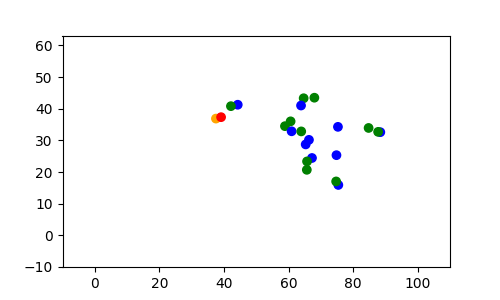

In [67]:
punt_tracking_2018_df.loc[:, COLUMN.FRAME] = punt_tracking_2018_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
    .apply(tuple, axis=1) \
    .rank(ascending=True, method='dense')

is_returner = np.where(punt_tracking_2018_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == punt_tracking_2018_df[COLUMN.NFL_ID].fillna(-2), True, False)

conditions = [
#     punt_tracking_2018_df[COLUMN.IS_GUNNER],
    is_returner,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL,
]
values = [
    'orange',
    'green',
    'blue',
    'red',
]
punt_tracking_2018_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
first_frame = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == 1]
c = first_frame[COLUMN.COLOR]
x = first_frame[COLUMN.X]
y = first_frame[COLUMN.Y]
scatter = ax.scatter(x, y, c=c)

def animate(i):
    filtered = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == i+1]
    c = filtered[COLUMN.COLOR]
    x = filtered[COLUMN.X]
    y = filtered[COLUMN.Y]
    data = np.c_[x, y]
    scatter.set_offsets(data)
    scatter.set_color(c)

animation = anm.FuncAnimation(
    fig,
    animate,
    interval=10,
    frames=int(punt_tracking_2018_df[COLUMN.FRAME].max()),
    repeat=True,
)
plt.show()

In [8]:
# Punt distance from sideline vs return distance
punt_tracking_2018_df['sidelineA'] = 53.3 - punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df['sidelineB'] = punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df[COLUMN.DISTANCE_FROM_SIDELINE] = punt_tracking_2018_df[['sidelineA', 'sidelineB']].min(axis=1)

<IPython.core.display.Javascript object>


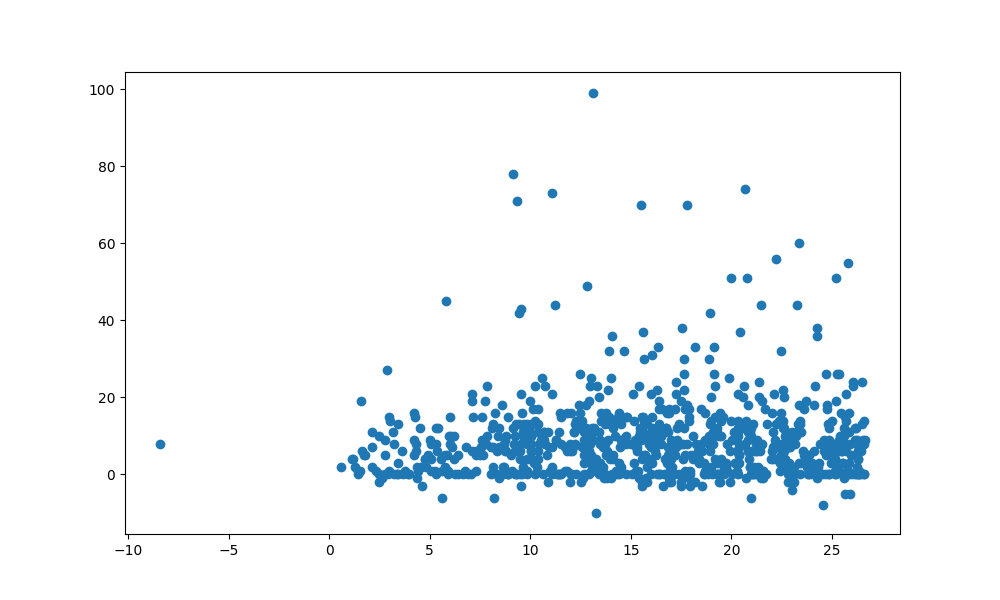

In [9]:
punt_received_football_only_df = punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_2018_df[COLUMN.TEAM] == 'football')
]
x = punt_received_football_only_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [10]:
x.corr(y)

0.035468871186775344

In [11]:
punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()

8.923543689320388

In [12]:
punt_received_football_only_df['aboveAverageReturn'] = \
    punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE] > punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()
punt_received_football_only_df[
    [COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE, 'aboveAverageReturn']
].head()

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_25972/3108297030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punt_received_football_only_df['aboveAverageReturn'] = \


,x,y,distanceFromSideline,kickReturnYardage,aboveAverageReturn
2893,72.61,39.18,14.12,5.0,False
7911,91.77,35.94,17.36,8.0,False
12720,82.02,42.04,11.26,9.0,True
19308,30.37,32.33,20.97,12.0,True
22523,36.61,44.87,8.43,-1.0,False


<IPython.core.display.Javascript object>


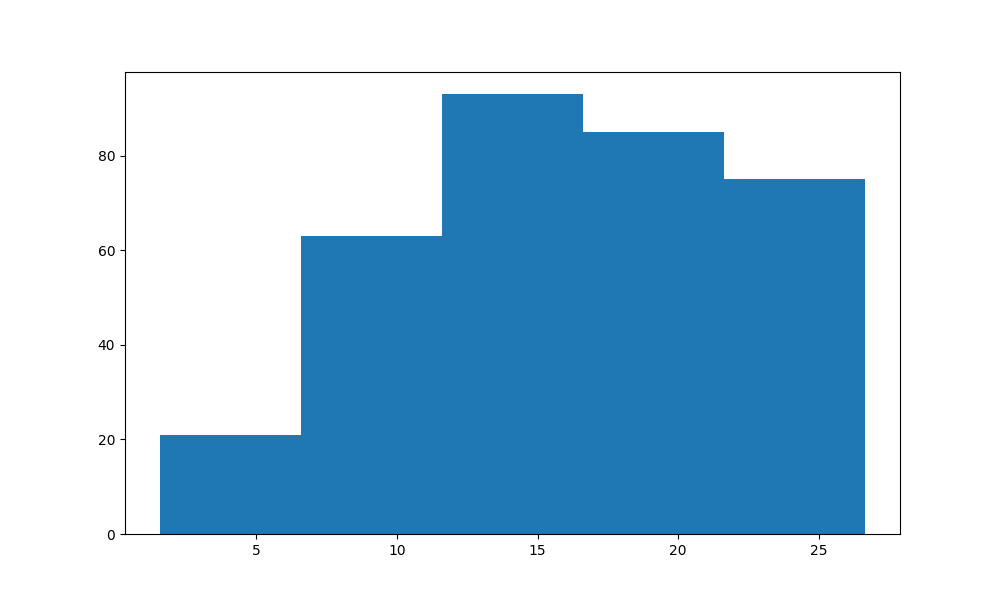

In [13]:
above_average_returns_df = punt_received_football_only_df[punt_received_football_only_df['aboveAverageReturn'] == True]
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
bins = 5
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x=x, bins=bins)
plt.show()

In [14]:
above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE].corr(above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE])

0.04671642827966678

<IPython.core.display.Javascript object>


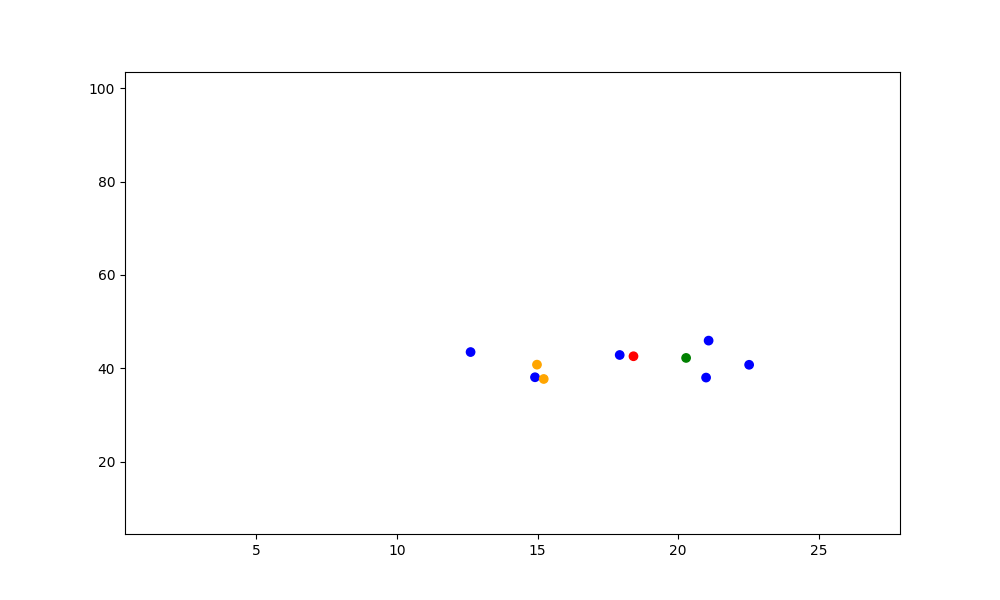

In [15]:
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [196]:
'''
Predict punt landing position based on pre-snap inputs (e.g. ball position)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
TODO:
  - Stack all 3 years of data
  - For inputs, filter tracking data to play event = ball_snap and special teams result
       is one of Return', 'Touchback', 'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
  - For outputs, filter to football position when special teams result is one of Return', 'Touchback',
       'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
       AND play event is one of punt_received, punt_land,
       fair_catch, punt_muffed
       AND team is football
  - Partition/sync inputs and outputs based on game id and play id
  - Partition data into training data and test data (80/20)
  - Use sklearn.linear_model.LinearRegression to train and test
  - Visualize results
  
A, B, C, D, E, F

A * x0 + B * x1 + C * x2 + D * x3 ... = ball landing position

                      SORT
x0 = ball x           1
x1 = ball y           2
x2 = punter x
x3 = punter y
x4 = returner x
x5 = returner y

y0 = ball landing x
y1 = ball landing y

football filter COLUMN.TEAM == 'football'
punter filter COLUMN.POSITION == 'P'
returner filter returnerId == nflId 
'''
special_teams_results = [
    SPECIAL_TEAMS_RESULT.RETURN,
    SPECIAL_TEAMS_RESULT.TOUCHBACK,
    SPECIAL_TEAMS_RESULT.FAIR_CATCH,
    SPECIAL_TEAMS_RESULT.DOWNED,
    SPECIAL_TEAMS_RESULT.MUFFED,
    SPECIAL_TEAMS_RESULT.OUT_OF_BOUNDS,
]
ball_land_events = [
    PLAY_EVENT.PUNT_RECEIVED,
    PLAY_EVENT.PUNT_LAND,
    PLAY_EVENT.FAIR_CATCH,
    PLAY_EVENT.PUNT_MUFFED,
]
punt_predict_df = punt_tracking_2018_df[
    punt_tracking_2018_df[COLUMN.SPECIAL_TEAMS_RESULT].isin(special_teams_results)
]

In [197]:
is_football = punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL
is_punter = punt_predict_df[COLUMN.POSITION] == POSITION.PUNTER
is_returner = (~np.isnan(punt_predict_df[COLUMN.PRIMARY_RETURNER_ID])) \
    & (~np.isnan(punt_predict_df[COLUMN.NFL_ID])) \
    & (punt_predict_df[COLUMN.PRIMARY_RETURNER_ID] == punt_predict_df[COLUMN.NFL_ID])
inputs_df = punt_predict_df[
    (punt_predict_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.BALL_SNAP)
    & ((is_football) | (is_punter) | (is_returner))
    & (punt_predict_df[COLUMN.RETURNER_ID].str.contains(';') == False) # filter out multiple returner scenarios
]

conditions = [
    (inputs_df[COLUMN.TEAM] == TEAM.FOOTBALL),
    (inputs_df[COLUMN.POSITION] == POSITION.PUNTER),
    np.where(inputs_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == inputs_df[COLUMN.NFL_ID].fillna(-2), True, False),
]
values = [1, 2, 3]
inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)

inputs_df = inputs_df.sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID, COLUMN.SORT_POSITION])

aggs = { 'x': lambda x: x.to_list(), 'y': lambda y: y.to_list() }
inputs_df = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID]).agg(aggs).reset_index()
inputs_df = inputs_df[
    (inputs_df[COLUMN.X].map(len) == 3)
    & (inputs_df[COLUMN.Y].map(len) == 3)
]
# Filter out plays where returner is near line of scrimmage
inputs_df = inputs_df[
    np.abs(inputs_df[COLUMN.X].str[0] - inputs_df[COLUMN.X].str[2]) > 10
]

def merge_coordinates(df):
    return [
        df[COLUMN.X][0],
        df[COLUMN.Y][0],
        df[COLUMN.X][1],
        df[COLUMN.Y][1],
        df[COLUMN.X][2],
        df[COLUMN.Y][2],
    ]

inputs_df['features'] = inputs_df.apply(merge_coordinates, axis=1)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_25972/3293556865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)


In [198]:
outputs_df = punt_predict_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT].isin(ball_land_events))
    & (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL)
].sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID])

def adjust_y(value):
    width = 53.3
    midline = width / 2
    if value < midline:
        return value
    else:
        return width - value

outputs_df['yAdjusted'] = outputs_df[COLUMN.Y].apply(adjust_y)

In [199]:
model_data_df = pd.merge(
    inputs_df,
    outputs_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

X = np.array(model_data_df['features'].tolist())
y = model_data_df[['x_y', 'y_y']].to_numpy()

In [200]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y', 'yAdjusted']].head(10)

,gameId,playId,x_x,y_x,features,x_y,y_y,yAdjusted
0,2018090600,366,"[17.9, 4.2, 67.05]","[29.94, 31.01, 26.31]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31]",72.61,39.18,14.12
1,2018090600,973,"[20.8, 7.04, 68.89]","[29.88, 29.32, 34.84]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84]",68.90,48.79,4.51
2,2018090600,1989,"[35.82, 22.04, 85.21]","[23.79, 23.28, 28.81]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81]",91.77,35.94,17.36
3,2018090600,2406,"[68.43, 81.79, 20.34]","[29.6, 28.88, 31.25]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25]",29.47,23.76,23.76
4,2018090600,2599,"[36.0, 22.03, 81.78]","[26.47, 26.11, 29.42]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42]",82.02,42.04,11.26
5,2018090600,3868,"[81.16, 94.96, 35.1]","[23.81, 22.94, 28.2]","[81.16, 23.81, 94.96, 22.94, 35.1, 28.2]",30.37,32.33,20.97
6,2018090900,485,"[82.0, 96.11, 36.87]","[29.87, 29.52, 30.99]","[82.0, 29.87, 96.11, 29.52, 36.87, 30.99]",36.61,44.87,8.43
7,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",90.69,48.90,4.40
8,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",98.16,52.11,1.19
9,2018090900,674,"[92.04, 106.19, 44.66]","[23.95, 23.23, 28.34]","[92.04, 23.95, 106.19, 23.23, 44.66, 28.34]",41.47,38.14,15.16


In [106]:
X

array([[ 17.9 ,  29.94,   4.2 ,  31.01,  67.05,  26.31],
       [ 20.8 ,  29.88,   7.04,  29.32,  68.89,  34.84],
       [ 35.82,  23.79,  22.04,  23.28,  85.21,  28.81],
       ...,
       [ 78.8 ,  29.83,  93.71,  28.83,  36.42,  32.31],
       [ 36.34,  29.8 ,  22.82,  29.4 ,  84.41,  30.94],
       [ 95.2 ,  23.75, 109.66,  23.95,  48.55,  19.67]])

In [107]:
y

array([[72.61, 39.18],
       [68.9 , 48.79],
       [91.77, 35.94],
       ...,
       [36.8 , 32.31],
       [86.27, 47.85],
       [33.62, 39.09]])

In [229]:
reg = LinearRegression().fit(X, y)

In [230]:
reg.score(X, y)

0.6319169701195959

In [155]:
reg.coef_

array([[ 3.41126324, -0.39633071, -2.78016801,  0.43009342],
       [ 0.2875841 ,  8.48069928, -0.21824164, -7.51463915]])

In [156]:
reg.intercept_

array([21.27850917, -3.19119311])

In [112]:
reg.predict(np.array([[17.9 ,  29.94,   4.2 ,  31.01,  67.05,  26.31]]))

array([[69.93396574, 20.66105354]])

In [231]:
model_data_df["prediction"] = reg.predict(X).tolist()

In [180]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y', 'prediction']].head(10)

,gameId,playId,x_x,y_x,features,x_y,y_y,prediction
0,2018090600,366,"[17.9, 4.2, 67.05]","[29.94, 31.01, 26.31]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31]",72.61,39.18,"[69.93396573573813, 15.440075790265784]"
1,2018090600,973,"[20.8, 7.04, 68.89]","[29.88, 29.32, 34.84]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84]",68.90,48.79,"[72.05889699611765, 15.05498826646797]"
2,2018090600,1989,"[35.82, 22.04, 85.21]","[23.79, 23.28, 28.81]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81]",91.77,35.94,"[85.07618169630345, 15.327807832894674]"
3,2018090600,2406,"[68.43, 81.79, 20.34]","[29.6, 28.88, 31.25]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25]",29.47,23.76,"[23.618329587654507, 14.98309794971593]"
4,2018090600,2599,"[36.0, 22.03, 81.78]","[26.47, 26.11, 29.42]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42]",82.02,42.04,"[82.74318525220946, 15.493659981694547]"
5,2018090600,3868,"[81.16, 94.96, 35.1]","[23.81, 22.94, 28.2]","[81.16, 23.81, 94.96, 22.94, 35.1, 28.2]",30.37,32.33,"[35.17216884455584, 14.829037169859534]"
6,2018090900,485,"[82.0, 96.11, 36.87]","[29.87, 29.52, 30.99]","[82.0, 29.87, 96.11, 29.52, 36.87, 30.99]",36.61,44.87,"[36.46640513945877, 14.889369903475044]"
7,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",90.69,48.90,"[82.12720562976264, 13.432420112438102]"
8,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",98.16,52.11,"[82.12720562976264, 13.432420112438102]"
9,2018090900,674,"[92.04, 106.19, 44.66]","[23.95, 23.23, 28.34]","[92.04, 23.95, 106.19, 23.23, 44.66, 28.34]",41.47,38.14,"[42.982485875028345, 14.727169870782166]"


<IPython.core.display.Javascript object>


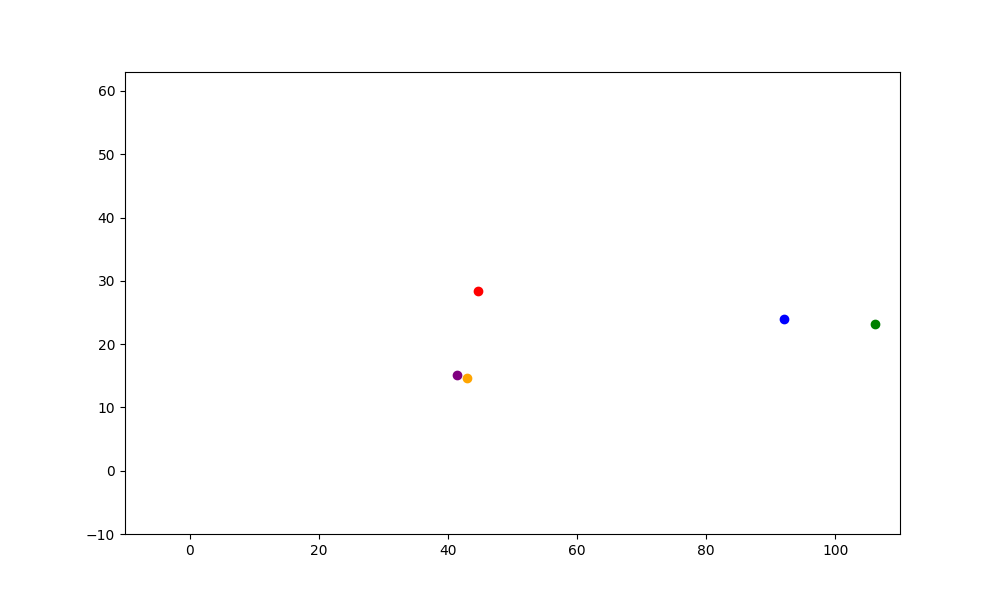

In [191]:
row = 9
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['prediction'][0]
predict_y = model_data_df.iloc[row]['prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [166]:
# Predict X
model_data_df['prediction'].str[0].describe()

count    1530.000000
mean       60.791118
std        28.034007
min        11.629800
25%        34.180566
50%        71.999888
75%        86.186894
max       109.433150
Name: prediction, dtype: float64

In [167]:
# Actual X
model_data_df['x_y'].describe()

count    1530.000000
mean       60.791118
std        29.030880
min        13.510000
25%        31.695000
50%        65.640000
75%        88.047500
max       109.640000
Name: x_y, dtype: float64

In [192]:
# Predict Y
model_data_df['prediction'].str[1].describe()

count    1519.000000
mean       15.374523
std         0.767793
min        11.958776
25%        14.867212
50%        15.370218
75%        15.878009
max        17.807662
Name: prediction, dtype: float64

In [193]:
# Actual Y
model_data_df['y_y'].describe()

count    1519.000000
mean       15.374523
std         6.741594
min        -8.400000
25%        10.195000
50%        15.880000
75%        20.885000
max        26.630000
Name: yAdjusted, dtype: float64

In [201]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

model = get_model(X.shape[1], y.shape[1])

2021-12-10 13:58:31.618494: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [222]:
model.fit(X, y, epochs=1000)

Epoch 1/1000
48/48 [==============================] - 0s 800us/step - loss: 7.1353
Epoch 2/1000
48/48 [==============================] - 0s 709us/step - loss: 7.1521
Epoch 3/1000
48/48 [==============================] - 0s 743us/step - loss: 7.1462
Epoch 4/1000
48/48 [==============================] - 0s 763us/step - loss: 7.1505
Epoch 5/1000
48/48 [==============================] - 0s 826us/step - loss: 7.1388
Epoch 6/1000
48/48 [==============================] - 0s 853us/step - loss: 7.1196
Epoch 7/1000
48/48 [==============================] - 0s 806us/step - loss: 7.1344
Epoch 8/1000
48/48 [==============================] - 0s 705us/step - loss: 7.1989
Epoch 9/1000
48/48 [==============================] - 0s 795us/step - loss: 7.1419
Epoch 10/1000
48/48 [==============================] - 0s 874us/step - loss: 7.1333
Epoch 11/1000
48/48 [==============================] - 0s 777us/step - loss: 7.1314
Epoch 12/1000
48/48 [==============================] - 0s 717us/step - loss: 7.1376
E

48/48 [==============================] - 0s 757us/step - loss: 7.0697
Epoch 99/1000
48/48 [==============================] - 0s 744us/step - loss: 7.0834
Epoch 100/1000
48/48 [==============================] - 0s 763us/step - loss: 7.0641
Epoch 101/1000
48/48 [==============================] - 0s 713us/step - loss: 7.0522
Epoch 102/1000
48/48 [==============================] - 0s 734us/step - loss: 7.0918
Epoch 103/1000
48/48 [==============================] - 0s 796us/step - loss: 7.1321
Epoch 104/1000
48/48 [==============================] - 0s 765us/step - loss: 7.1160
Epoch 105/1000
48/48 [==============================] - 0s 753us/step - loss: 7.0493
Epoch 106/1000
48/48 [==============================] - 0s 770us/step - loss: 7.0702
Epoch 107/1000
48/48 [==============================] - 0s 721us/step - loss: 7.1360
Epoch 108/1000
48/48 [==============================] - 0s 811us/step - loss: 7.0872
Epoch 109/1000
48/48 [==============================] - 0s 786us/step - loss: 7.0

48/48 [==============================] - 0s 779us/step - loss: 7.0867
Epoch 195/1000
48/48 [==============================] - 0s 744us/step - loss: 7.0467
Epoch 196/1000
48/48 [==============================] - 0s 674us/step - loss: 7.0460
Epoch 197/1000
48/48 [==============================] - 0s 728us/step - loss: 7.0202
Epoch 198/1000
48/48 [==============================] - 0s 768us/step - loss: 7.0588
Epoch 199/1000
48/48 [==============================] - 0s 717us/step - loss: 7.0822
Epoch 200/1000
48/48 [==============================] - 0s 675us/step - loss: 7.0868
Epoch 201/1000
48/48 [==============================] - 0s 732us/step - loss: 7.0662
Epoch 202/1000
48/48 [==============================] - 0s 743us/step - loss: 7.0457
Epoch 203/1000
48/48 [==============================] - 0s 726us/step - loss: 7.0708
Epoch 204/1000
48/48 [==============================] - 0s 768us/step - loss: 7.0436
Epoch 205/1000
48/48 [==============================] - 0s 699us/step - loss: 7.

48/48 [==============================] - 0s 737us/step - loss: 7.0441
Epoch 291/1000
48/48 [==============================] - 0s 807us/step - loss: 7.0392
Epoch 292/1000
48/48 [==============================] - 0s 853us/step - loss: 7.0131
Epoch 293/1000
48/48 [==============================] - 0s 735us/step - loss: 7.0189
Epoch 294/1000
48/48 [==============================] - 0s 791us/step - loss: 7.0175
Epoch 295/1000
48/48 [==============================] - 0s 821us/step - loss: 7.0293
Epoch 296/1000
48/48 [==============================] - 0s 764us/step - loss: 7.0171
Epoch 297/1000
48/48 [==============================] - 0s 790us/step - loss: 7.0517
Epoch 298/1000
48/48 [==============================] - 0s 757us/step - loss: 7.0237
Epoch 299/1000
48/48 [==============================] - 0s 762us/step - loss: 7.0608
Epoch 300/1000
48/48 [==============================] - 0s 748us/step - loss: 7.0716
Epoch 301/1000
48/48 [==============================] - 0s 817us/step - loss: 7.

48/48 [==============================] - 0s 745us/step - loss: 6.9845
Epoch 387/1000
48/48 [==============================] - 0s 805us/step - loss: 7.0779
Epoch 388/1000
48/48 [==============================] - 0s 749us/step - loss: 7.0469
Epoch 389/1000
48/48 [==============================] - 0s 746us/step - loss: 7.0216
Epoch 390/1000
48/48 [==============================] - 0s 782us/step - loss: 7.0093
Epoch 391/1000
48/48 [==============================] - 0s 733us/step - loss: 7.0273
Epoch 392/1000
48/48 [==============================] - 0s 803us/step - loss: 7.0311
Epoch 393/1000
48/48 [==============================] - 0s 751us/step - loss: 7.0242
Epoch 394/1000
48/48 [==============================] - 0s 718us/step - loss: 7.0041
Epoch 395/1000
48/48 [==============================] - 0s 803us/step - loss: 7.0294
Epoch 396/1000
48/48 [==============================] - 0s 797us/step - loss: 7.0383
Epoch 397/1000
48/48 [==============================] - 0s 773us/step - loss: 7.

48/48 [==============================] - 0s 753us/step - loss: 6.9903
Epoch 483/1000
48/48 [==============================] - 0s 828us/step - loss: 6.9925
Epoch 484/1000
48/48 [==============================] - 0s 754us/step - loss: 7.0214
Epoch 485/1000
48/48 [==============================] - 0s 783us/step - loss: 6.9644
Epoch 486/1000
48/48 [==============================] - 0s 769us/step - loss: 6.9680
Epoch 487/1000
48/48 [==============================] - 0s 783us/step - loss: 6.9742
Epoch 488/1000
48/48 [==============================] - 0s 826us/step - loss: 6.9711
Epoch 489/1000
48/48 [==============================] - 0s 877us/step - loss: 6.9621
Epoch 490/1000
48/48 [==============================] - 0s 758us/step - loss: 7.0236
Epoch 491/1000
48/48 [==============================] - 0s 863us/step - loss: 6.9641
Epoch 492/1000
48/48 [==============================] - 0s 825us/step - loss: 6.9876
Epoch 493/1000
48/48 [==============================] - 0s 848us/step - loss: 6.

48/48 [==============================] - 0s 754us/step - loss: 6.9897
Epoch 579/1000
48/48 [==============================] - 0s 855us/step - loss: 6.9427
Epoch 580/1000
48/48 [==============================] - 0s 778us/step - loss: 7.0078
Epoch 581/1000
48/48 [==============================] - 0s 842us/step - loss: 7.0063
Epoch 582/1000
48/48 [==============================] - 0s 737us/step - loss: 6.9711
Epoch 583/1000
48/48 [==============================] - 0s 716us/step - loss: 6.9586
Epoch 584/1000
48/48 [==============================] - 0s 770us/step - loss: 6.9715
Epoch 585/1000
48/48 [==============================] - 0s 787us/step - loss: 6.9455
Epoch 586/1000
48/48 [==============================] - 0s 773us/step - loss: 6.9534
Epoch 587/1000
48/48 [==============================] - 0s 713us/step - loss: 7.1114
Epoch 588/1000
48/48 [==============================] - 0s 838us/step - loss: 6.9594
Epoch 589/1000
48/48 [==============================] - 0s 751us/step - loss: 6.

48/48 [==============================] - 0s 842us/step - loss: 6.9431
Epoch 675/1000
48/48 [==============================] - 0s 893us/step - loss: 6.9201
Epoch 676/1000
48/48 [==============================] - 0s 774us/step - loss: 6.9578
Epoch 677/1000
48/48 [==============================] - 0s 737us/step - loss: 6.9412
Epoch 678/1000
48/48 [==============================] - 0s 803us/step - loss: 6.9164
Epoch 679/1000
48/48 [==============================] - 0s 840us/step - loss: 6.9627
Epoch 680/1000
48/48 [==============================] - 0s 781us/step - loss: 6.9467
Epoch 681/1000
48/48 [==============================] - 0s 779us/step - loss: 6.9640
Epoch 682/1000
48/48 [==============================] - 0s 790us/step - loss: 6.9619
Epoch 683/1000
48/48 [==============================] - 0s 796us/step - loss: 6.9422
Epoch 684/1000
48/48 [==============================] - 0s 873us/step - loss: 6.9848
Epoch 685/1000
48/48 [==============================] - 0s 811us/step - loss: 6.

48/48 [==============================] - 0s 806us/step - loss: 6.9184
Epoch 771/1000
48/48 [==============================] - 0s 797us/step - loss: 6.8914
Epoch 772/1000
48/48 [==============================] - 0s 746us/step - loss: 6.9164
Epoch 773/1000
48/48 [==============================] - 0s 797us/step - loss: 6.9207
Epoch 774/1000
48/48 [==============================] - 0s 813us/step - loss: 6.9459
Epoch 775/1000
48/48 [==============================] - 0s 757us/step - loss: 6.9192
Epoch 776/1000
48/48 [==============================] - 0s 740us/step - loss: 6.9111
Epoch 777/1000
48/48 [==============================] - 0s 790us/step - loss: 6.9215
Epoch 778/1000
48/48 [==============================] - 0s 827us/step - loss: 6.9165
Epoch 779/1000
48/48 [==============================] - 0s 717us/step - loss: 6.9290
Epoch 780/1000
48/48 [==============================] - 0s 739us/step - loss: 6.9303
Epoch 781/1000
48/48 [==============================] - 0s 826us/step - loss: 6.

48/48 [==============================] - 0s 774us/step - loss: 6.9323
Epoch 867/1000
48/48 [==============================] - 0s 842us/step - loss: 6.8898
Epoch 868/1000
48/48 [==============================] - 0s 819us/step - loss: 6.8861
Epoch 869/1000
48/48 [==============================] - 0s 769us/step - loss: 6.9362
Epoch 870/1000
48/48 [==============================] - 0s 770us/step - loss: 6.9025
Epoch 871/1000
48/48 [==============================] - 0s 788us/step - loss: 6.9242
Epoch 872/1000
48/48 [==============================] - 0s 837us/step - loss: 6.8765
Epoch 873/1000
48/48 [==============================] - 0s 817us/step - loss: 6.8961
Epoch 874/1000
48/48 [==============================] - 0s 725us/step - loss: 6.8642
Epoch 875/1000
48/48 [==============================] - 0s 855us/step - loss: 6.8920
Epoch 876/1000
48/48 [==============================] - 0s 851us/step - loss: 6.8619
Epoch 877/1000
48/48 [==============================] - 0s 796us/step - loss: 6.

48/48 [==============================] - 0s 764us/step - loss: 6.8468
Epoch 963/1000
48/48 [==============================] - 0s 794us/step - loss: 6.8499
Epoch 964/1000
48/48 [==============================] - 0s 797us/step - loss: 6.8791
Epoch 965/1000
48/48 [==============================] - 0s 743us/step - loss: 6.8720
Epoch 966/1000
48/48 [==============================] - 0s 780us/step - loss: 6.9343
Epoch 967/1000
48/48 [==============================] - 0s 772us/step - loss: 6.8459
Epoch 968/1000
48/48 [==============================] - 0s 785us/step - loss: 6.8947
Epoch 969/1000
48/48 [==============================] - 0s 789us/step - loss: 6.8855
Epoch 970/1000
48/48 [==============================] - 0s 767us/step - loss: 6.8487
Epoch 971/1000
48/48 [==============================] - 0s 771us/step - loss: 6.8604
Epoch 972/1000
48/48 [==============================] - 0s 858us/step - loss: 6.8857
Epoch 973/1000
48/48 [==============================] - 0s 822us/step - loss: 6.

In [223]:
model_data_df["nn_prediction"] = model.predict(X).tolist()

<IPython.core.display.Javascript object>


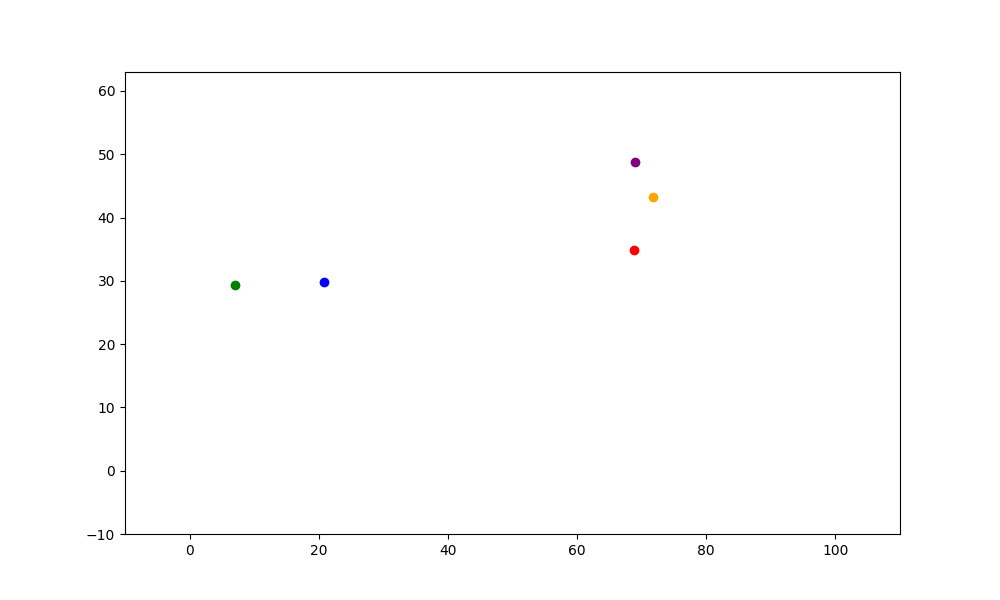

In [225]:
row = 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['nn_prediction'][0]
predict_y = model_data_df.iloc[row]['nn_prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [237]:
model_data_df['linearRegressionDistance'] = (
    (model_data_df['x_y'] - model_data_df['prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['prediction'].str[1]) ** 2
) ** 0.5
model_data_df['neuralNetworkDistance'] = (
    (model_data_df['x_y'] - model_data_df['nn_prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['nn_prediction'].str[1]) ** 2
) ** 0.5

In [238]:
model_data_df['linearRegressionDistance'].mean()

11.073877284187004

In [239]:
model_data_df['neuralNetworkDistance'].mean()

10.971497519005773